In [1]:
import torch
import torchvision

In [2]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 100

random_seed = 1
#torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

# Loading the data

In [3]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('data/mnist', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('data/mnist', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

100.1%

Extracting data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to data/mnist/MNIST/raw


113.5%

Extracting data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to data/mnist/MNIST/raw


100.4%

Extracting data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to data/mnist/MNIST/raw


180.4%/home/c01ekar/anaconda3/envs/ae/lib/python3.7/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370128159/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Extracting data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/mnist/MNIST/raw
Processing...
Done!


In [4]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

torch.Size([1000, 1, 28, 28])

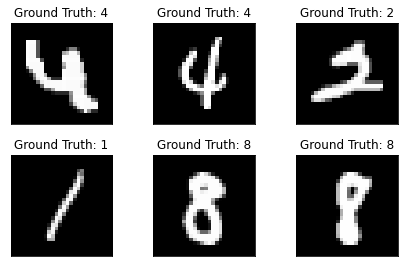

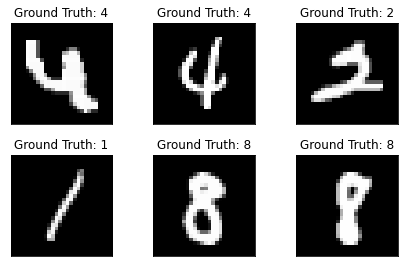

In [5]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
fig

# Building the network

In [6]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        self.mask = torch.ones(10, 50)
        self.original_w = None

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        self.last_layer = F.relu(self.fc1(x))
        x = F.dropout(self.last_layer, training=self.training)
        self.fc2.weight = nn.Parameter(self.fc2.weight * self.mask)
        x = self.fc2(x)
        return F.log_softmax(x)
    
    def set_mask(self, mask):
        if self.original_w is None:
            self.original_w = self.fc2.weight
        else:
            self.fc2.weight = self.original_w
        self.mask = mask

In [8]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

# Training

In [9]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [10]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        print(data.shape)
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        #l0.3 regularization
        #l = torch.tensor(0.001)
        #reg = torch.tensor(0.)
        #for param in network.parameters():
        #    reg += torch.norm(param, p=0.9)
        #loss += l * reg    
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append(
            (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            torch.save(network.state_dict(), 'model.pth')
            torch.save(optimizer.state_dict(), 'optimizer.pth')

In [11]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    ll_activations = []
    pred_lst = []
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
            pred_lst.append(output.data)
            ll_activations.append(network.last_layer)
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))
    return torch.cat(ll_activations), torch.cat(pred_lst)

In [12]:
import numpy as np

merged = []
test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    ll_act, pred = test()
    merged = np.hstack((ll_act, pred))

/home/c01ekar/anaconda3/envs/ae/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/home/c01ekar/anaconda3/envs/ae/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3089, Accuracy: 674/10000 (7%)

torch.Size([64, 1, 28, 28])
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.368649
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
tor

torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.038206
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28]

torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.576230
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28]

torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.730263
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28]

torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 2

torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 2

torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 2

torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.462235
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28]

torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.50267

torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 2

/home/c01ekar/anaconda3/envs/ae/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/c01ekar/anaconda3/envs/ae/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


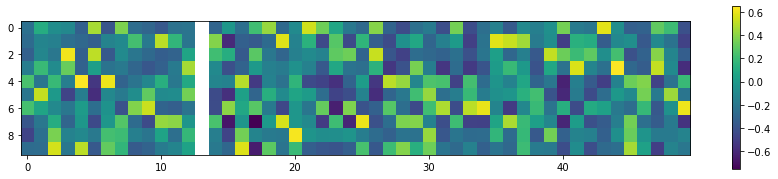

In [13]:
plt.figure(figsize=(15,3))
corrm = np.corrcoef(np.transpose(merged))[-10:, :-10]
plt.imshow(corrm)
plt.colorbar()

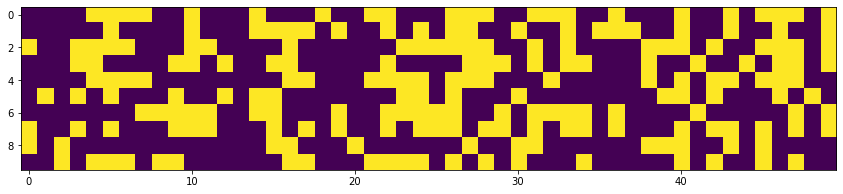

In [14]:
corr_thr = 0.3
plt.figure(figsize=(15,3))
plt.imshow(np.abs(corrm)>corr_thr)

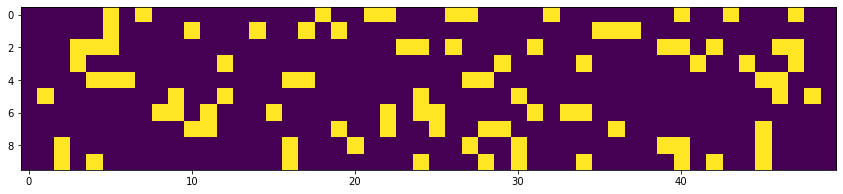

In [19]:
w_thr = 0.03
plt.figure(figsize=(15,3))
plt.imshow((np.abs(corrm)>corr_thr) * (network.fc2.weight>w_thr).numpy())

1


/home/c01ekar/anaconda3/envs/ae/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



Test set: Avg. loss: 0.1325, Accuracy: 9638/10000 (96%)



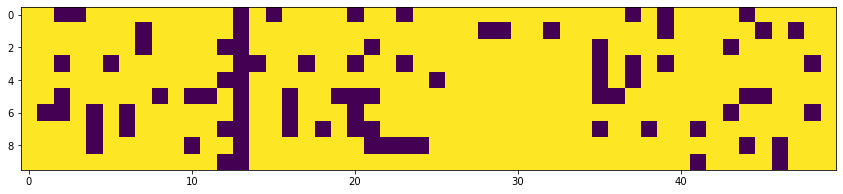

2

Test set: Avg. loss: 0.1972, Accuracy: 9486/10000 (95%)



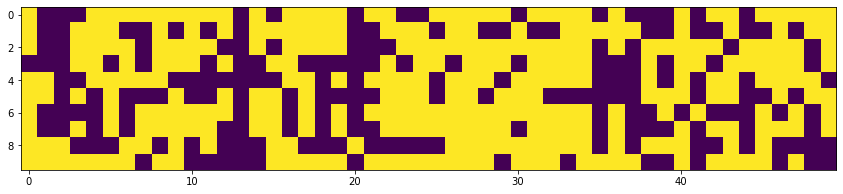

3

Test set: Avg. loss: 0.2974, Accuracy: 9377/10000 (94%)



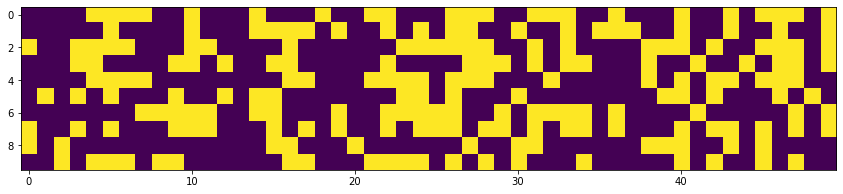

4

Test set: Avg. loss: 0.5378, Accuracy: 8433/10000 (84%)



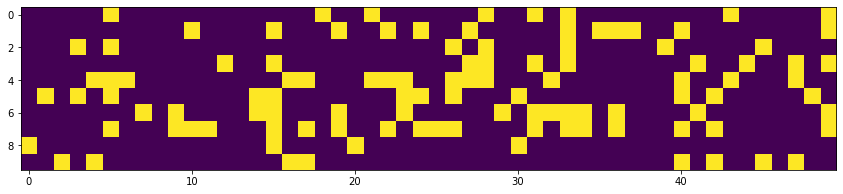

5

Test set: Avg. loss: 0.8633, Accuracy: 7914/10000 (79%)



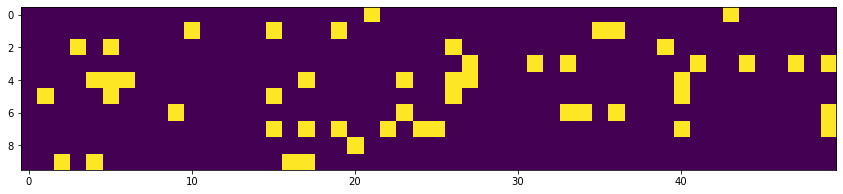

6

Test set: Avg. loss: 1.6852, Accuracy: 5806/10000 (58%)



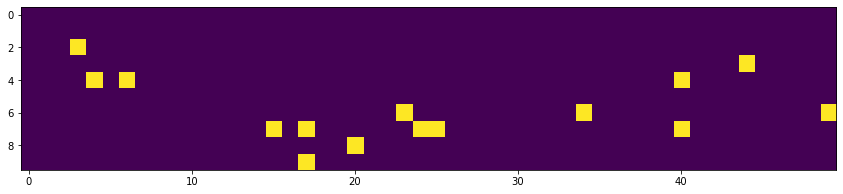

7

Test set: Avg. loss: 2.2686, Accuracy: 892/10000 (9%)



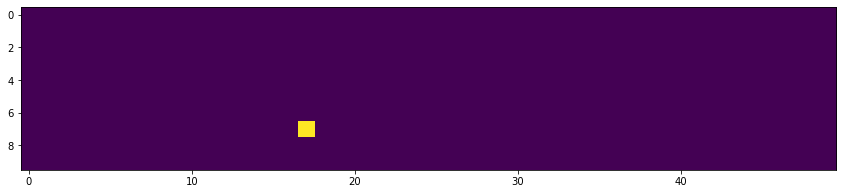

8

Test set: Avg. loss: 2.3416, Accuracy: 892/10000 (9%)



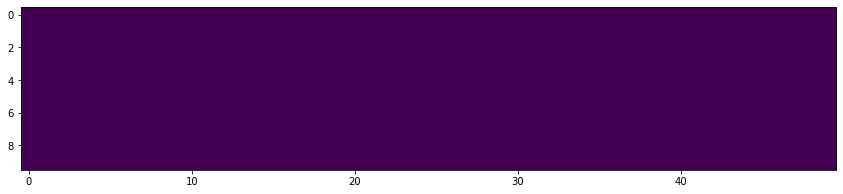

9

Test set: Avg. loss: 2.3416, Accuracy: 892/10000 (9%)



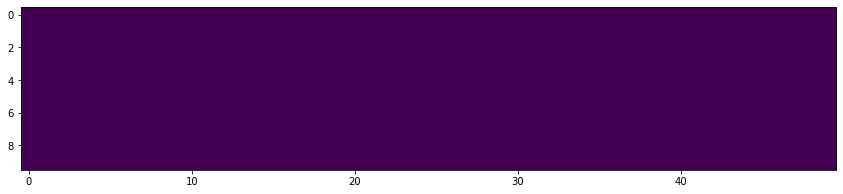

In [22]:
#network.mask = torch.tensor((np.abs(corrm)>corr_thr).astype(float)).float()
for c in range(1, 10):
    network.set_mask(torch.tensor((np.abs(corrm)>c/10).astype(float)).float())
    print(c)
    test()
    
    plt.figure(figsize=(15,3))
    plt.imshow(np.abs(corrm)>c/10)
    plt.show()

In [23]:
network.set_mask(torch.ones(10, 50))
w = network.fc2.weight
for c in range(1, 20):
    network.set_mask(torch.tensor((w>c/100)).float())
    print(c/100)
    test()

/home/c01ekar/anaconda3/envs/ae/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


0.01


/home/c01ekar/anaconda3/envs/ae/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



Test set: Avg. loss: 0.1741, Accuracy: 9656/10000 (97%)

0.02

Test set: Avg. loss: 0.1730, Accuracy: 9653/10000 (97%)

0.03

Test set: Avg. loss: 0.1746, Accuracy: 9647/10000 (96%)

0.04

Test set: Avg. loss: 0.1781, Accuracy: 9639/10000 (96%)

0.05

Test set: Avg. loss: 0.1891, Accuracy: 9604/10000 (96%)

0.06

Test set: Avg. loss: 0.2044, Accuracy: 9580/10000 (96%)

0.07

Test set: Avg. loss: 0.2179, Accuracy: 9565/10000 (96%)

0.08

Test set: Avg. loss: 0.2462, Accuracy: 9502/10000 (95%)

0.09

Test set: Avg. loss: 0.3183, Accuracy: 9363/10000 (94%)

0.1

Test set: Avg. loss: 0.4872, Accuracy: 8854/10000 (89%)

0.11

Test set: Avg. loss: 0.7186, Accuracy: 7603/10000 (76%)

0.12

Test set: Avg. loss: 1.0262, Accuracy: 6592/10000 (66%)

0.13

Test set: Avg. loss: 1.5158, Accuracy: 4721/10000 (47%)

0.14

Test set: Avg. loss: 2.1443, Accuracy: 2085/10000 (21%)

0.15

Test set: Avg. loss: 2.3416, Accuracy: 892/10000 (9%)

0.16


KeyboardInterrupt: 

In [24]:
act = [[] for i in range(10)]
for num, neu in zip(*np.where(network.mask > 0)):
    act[num].append(neu)
s = list(set([item for sublist in act for item in sublist]))
mapping = {a: i for i, a in enumerate(s)}
act_remapped = [[mapping[i] for i in sublist] for sublist in act]
act_remapped

[[], [], [], [], [], [], [], [], [], []]

In [25]:
network.set_mask(torch.ones(10, 50))
w = network.fc2.weight
corr_thr = 0.3
w_thr = 0.03
print("Connections with corr >{} : {}%".format(corr_thr, len(np.where(np.abs(corrm)>corr_thr)[0])/500*100))
print("Connections with corr >{} and w > {}: {}%".format(corr_thr, w_thr, len(np.where((np.abs(corrm)>corr_thr) * (w >w_thr))[0])/500*100))
print("Connections with corr >{} or w > {}: {}%".format(corr_thr, w_thr, len(np.where((np.abs(corrm)>corr_thr) + (w >w_thr))[0])/500*100))

Connections with corr >0.3 : 40.6%


TypeError: unsupported operand type(s) for *: 'numpy.ndarray' and 'Tensor'

In [28]:
network.set_mask(torch.tensor((np.abs(corrm)>0.2).astype(float)*(w.detach().numpy()>0.03)).float())
test()

/home/c01ekar/anaconda3/envs/ae/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



Test set: Avg. loss: 0.3075, Accuracy: 9390/10000 (94%)



(tensor([[ 1.4002,  3.3613,  0.0000,  ...,  0.0000,  0.0000,  7.1572],
         [ 1.4737, 11.2993,  0.0000,  ...,  1.6469,  7.1062,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  1.1245,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 5.0286,  2.9854,  0.0000,  ...,  0.0000,  0.0000, 19.4086],
         [ 0.0000,  0.0000,  0.0000,  ...,  4.1610,  6.0177,  0.0000]]),
 tensor([[-4.5090e+00, -4.8753e+00, -3.2330e+00,  ..., -4.8936e+00,
          -4.4066e+00, -3.9558e+00],
         [-3.6952e+00, -5.6469e+00, -4.9915e+00,  ..., -4.5932e+00,
          -4.2016e+00, -3.8464e+00],
         [-7.5302e+00, -2.3741e+00, -5.0715e+00,  ..., -1.1767e-01,
          -6.2910e+00, -6.8769e+00],
         ...,
         [-7.6973e+00, -4.8803e+00, -7.4979e+00,  ..., -1.1909e-02,
          -6.5348e+00, -7.3910e+00],
         [-8.3244e+00, -1.1327e+01, -7.7318e+00,  ..., -1.2841e+01,
          -1.1428e+01, -5.2683e+00],
         [-6.3854e-

In [30]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)
network.set_mask(torch.tensor((np.abs(corrm)>0.2).astype(float)*(w.detach().numpy()>0.03)).float())

135


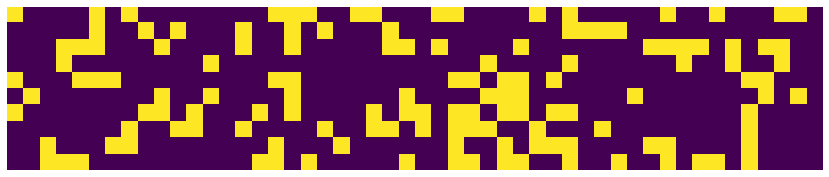

In [33]:
plt.figure(figsize=(15,3))
plt.imshow(network.mask)
plt.axis('off')
print(len(torch.nonzero(network.mask)))

In [32]:
merged = []
test()
print(len(torch.nonzero(network.mask)))
for epoch in range(1, n_epochs + 1):
    train(epoch)
    print(len(torch.nonzero(network.mask)))
    ll_act, pred = test()
    print(ll_act.shape, pred.shape)
    merged = np.hstack((ll_act, pred))

/home/c01ekar/anaconda3/envs/ae/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



Test set: Avg. loss: 2.3106, Accuracy: 1285/10000 (13%)

135
torch.Size([64, 1, 28, 28])
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.294172
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28

torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.517671
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28]

torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.947591
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28]

torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.783525
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28]

torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 2

torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 2

torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 2

torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.595635
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28]

torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.456548
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28]

torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 2

In [ ]:
plt.figure(figsize=(15,3))
plt.imshow(network.mask)
plt.colorbar()
test()

In [ ]:
l = []
for p in network.parameters():
    l.append(p.data.flatten())
l = torch.cat(l)

In [ ]:
plt.hist(l, bins=500, range=(-1, 1))

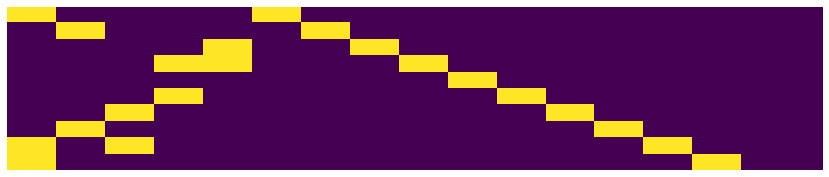

In [18]:
subgroups = [[0, 5],
             [1, 6],
             [4, 7],
             [3, 4, 8],
             [9],
             [3, 10],
             [2, 11],
             [1, 12],
             [0, 2, 13],
             [0, 14]
             ]
sg_size = 3
mask = torch.zeros(10, 50)
for i, s in enumerate(subgroups):
    #self.subgroups.append([x*sg_size+i for x in s for i in range(sg_size)])
    for x in s:
        mask[i, x*sg_size:x*sg_size+sg_size]=1
    
plt.figure(figsize=(15,3))
plt.axis('off')
plt.imshow(mask)
#plt.colorbar()

In [ ]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)
network.set_mask(torch.tensor(mask).float())
merged = []
test()
print(len(torch.nonzero(network.mask)))
for epoch in range(1, n_epochs + 1):
    train(epoch)
    print(len(torch.nonzero(network.mask)))
    ll_act, pred = test()
    print(ll_act.shape, pred.shape)
    merged = np.hstack((ll_act, pred))

In [ ]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)
network.set_mask(torch.zeros(10, 50).float())
merged = []
test()
print(len(torch.nonzero(network.mask)))
for epoch in range(1, n_epochs + 1):
    train(epoch)
    print(len(torch.nonzero(network.mask)))
    ll_act, pred = test()
    print(ll_act.shape, pred.shape)
    merged = np.hstack((ll_act, pred))

In [ ]:
import numpy as np

plt.figure(figsize=(15,15))
plt.imshow(np.corrcoef(np.transpose(merged)))
